In [1]:
import numpy as np
import matplotlib.pyplot as plt

 ## Data For regression

In [2]:
# making random data for regression
from sklearn.datasets import make_regression

In [3]:
X, y = make_regression(n_samples=500, n_features=1, n_targets=1, noise=69, random_state=420)
y = y[:,np.newaxis]

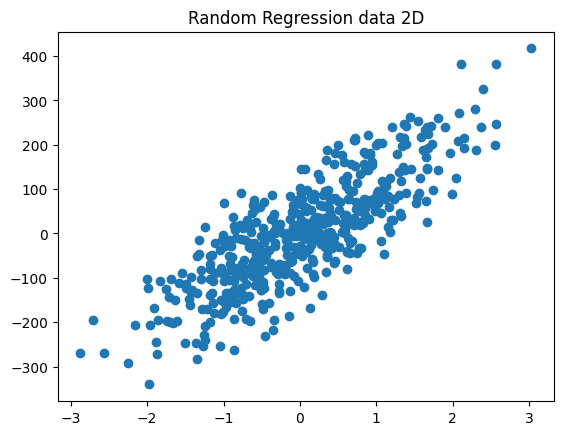

In [4]:
plt.figure()
plt.title("Random Regression data 2D")
plt.scatter(X,y)

In [5]:
X2, y2 = make_regression(n_samples=500, n_features=2, n_targets=1, noise=69, random_state=420)
y2 = y2[:, np.newaxis] # only in case of single feature

Text(0.5, 0, 'Target')

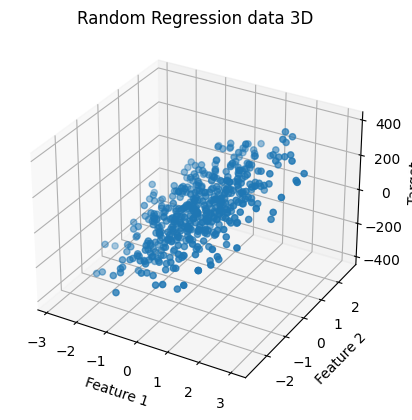

In [6]:
fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')
ax.scatter(X2[:,0],X2[:,1],y2)

ax.set_title("Random Regression data 3D")
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_zlabel('Target')

## Linear regresion metrics
### Computing different metrics

In [7]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [8]:
def metrics(y_true,y_pred):
    mse = mean_squared_error(y_true, y_pred)
    print("MSE: ", mse)
    rmse = np.sqrt(mse)
    print("RMSE: ", rmse)
    mae = mean_absolute_error(y_true, y_pred)
    print("MAE: ", mae)
    r2 = r2_score(y_true, y_pred)
    print("R2: ", r2)
    print()

## Simple Least Squares 
$\hat y = mx_i + c$, our Error function $E = \sum (\hat y - y_i)^2$
then, 
$$
E = \sum ((mx_i + c) - y_i)^2
$$
where m is the slope and c is the intercept.
by equating the resulting equation to zero, 
$$
m = \frac {\sum (x_i - \bar x) (y_i - \bar y)} {\sum (x_i -\bar x)^2}
$$
and,
$$
c = \bar y - m(\bar x)
$$

In [9]:
def least_squares(X,y):
    x_bar = np.mean(X)
    y_bar = np.mean(y)
    N = len(X)
    # for slope
    n,d=0,0
    for i in range(N):
        n += (X[i] - x_bar) * (y[i] - y_bar)
        d += (X[i] - x_bar)**2
    m = n/d # slope
    c = y_bar - m * x_bar # intercept
    
    return m, c    

In [10]:
m, c = least_squares(X,y)
m,c

(array([101.51804296]), array([-1.33238682]))

In [11]:
y_hat = lambda x: m*x + c

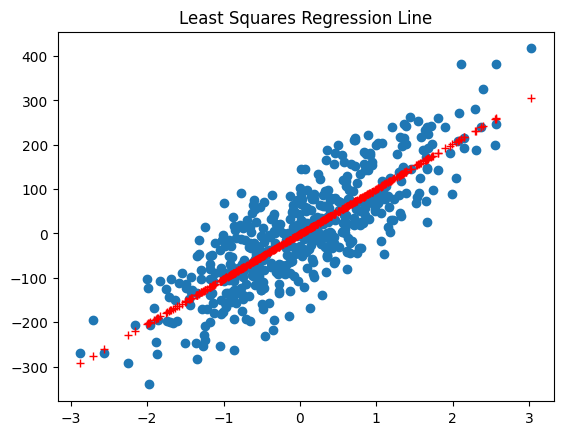

In [12]:
plt.figure()
plt.title("Least Squares Regression Line")
plt.scatter(X,y)
plt.plot(X,y_hat(X),'+r')

## Ordinary Least Squares
$$
t = y(x,w)+ \epsilon
$$
$\mathrm{w}_{ML} = (Φ^T Φ)^{-1} Φ^T \mathbf{t}$

noise term: $\frac{1}{\beta_{ML}} = \frac 1 N \sum^N_{n=1} \{t_n - 
\mathrm{w}_{ML}^T  \phi(x_n) \}^2$

bias term (intercept) which will be Wml[0]: $w_0 = \overline{t} − \sum^{M-1}_{j=1} w_j \overline{\phi_j}$

In [13]:
def ordinary_least_square(X,y):
    N = len(X)
    Phi = np.hstack((np.ones((N, 1)), X)) # design matrix
    pseudo_inverse = np.linalg.inv(Phi.T @ Phi) @ Phi.T # or np.linalg.pinv(Phi)
    Wml = pseudo_inverse @ y
    
    precision = 0
    for n in range(N):
        precision += (y[n] - Wml.T @ Phi[n])**2
    precision *= 1/N
    
    return Wml, np.sqrt(precision)

In [14]:
def y_hat2(x,W):
    x = np.hstack((np.ones((len(x), 1)), x))
    return np.array([W.T@xi for xi in x])

In [15]:
Wml, epsilon = ordinary_least_square(X,y)
Wml,epsilon

(array([[ -1.33238682],
        [101.51804296]]),
 array([69.35172149]))

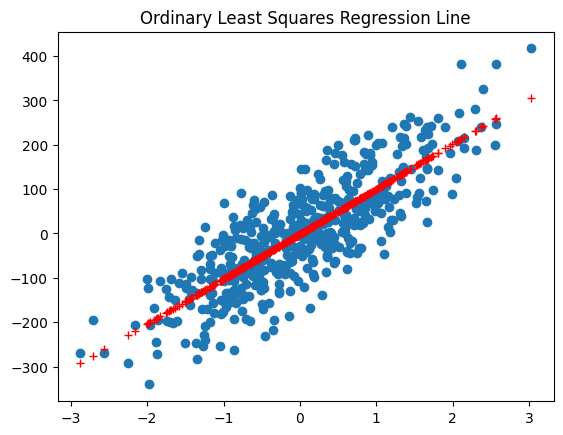

In [16]:
plt.figure()
plt.title("Ordinary Least Squares Regression Line")
plt.scatter(X,y)
plt.plot(X,y_hat2(X,Wml),'+r')

In [17]:
Wml3, epsilon3 = ordinary_least_square(X2,y2)
Wml3,epsilon3

(array([[ 0.32912885],
        [93.61383132],
        [66.22565924]]),
 array([71.89920192]))

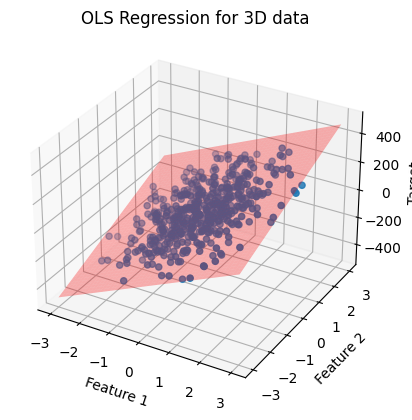

In [18]:
# %matplotlib notebook
p = np.linspace(-3, 3, 1000)
u, v = np.meshgrid(p, p)
points = np.column_stack([u.flatten(), v.flatten()])
predictions = y_hat2(points,Wml3)
w = predictions.reshape(u.shape)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(u, v, w, alpha=.3,color="red")
ax.scatter(X2[:,0],X2[:,1],y2)
ax.set_title("OLS Regression for 3D data")
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_zlabel('Target')
plt.show()


## Bayesian Linear Regression

priro distribution,
$$
p(t|w) = \prod_{n=1}^N  \mathcal{N}(t_n |w^T \phi{(x_n)}, β^{−1} )
$$

posterior distribution,
$$
p(w|t) = \mathcal{N} (w|m_N , S_N )
$$
where,
$$
m_N = S_N(S_0^{-1}m_0 + \beta \Phi^Tt) \\
S_N^{-1} = S_0^{-1} + \beta \Phi^T \Phi
$$
predictive function,
$$
p(t|x, \mathbf t, α, β) = \mathcal N (t|m^T_N \phi(x), σ^2_N (x))
$$
where $σ^2_N (x) = \frac 1 \beta  + \phi (x)^T S_N \phi(x)
$

the maximum posterior weight vector is simply given by $w_{MAP} = m_N$ If we consider an inﬁnitely broad prior $S_0 = α^{−1} I$ with $α → 0$, the mean $m_N$ of the posterior distribution reduces to the maximum likelihood value $w_{ML}$.

In [19]:

class BayesianLinearRegression():
    def __init__(self, alpha=1, beta=1):
        self.alpha = alpha   # precision of the prior distribution
        self.beta = beta     # precision of the noise distribution
        self.mN = None   # posterior mean of weights
        self.sN = None    # posterior covariance matrix of weights
    
    def fit(self, X, y):
        Phi = np.hstack((np.ones((X.shape[0], 1)), X))
        
        # prior distribution over weights: w ~ N(w|0, alpha*I)
        I = np.eye(Phi.shape[1])
        m0 = np.zeros((Phi.shape[1], 1))
        s0 = (1/self.alpha) * I
        
        # posterior distribution over weights
        self.sN = np.linalg.inv((1/self.beta) * np.dot(Phi.T, Phi) + s0)
        self.mN = np.dot(self.sN, (1/self.beta) * np.dot(Phi.T, y) + np.dot(s0, m0))
        

    def distribution(self, X_test):
        Phi = np.hstack((np.ones((X_test.shape[0], 1)), X_test))
        
        # compute predictive mean and variance
        m_N = np.dot(Phi,self.mN)
        sigma_N_squared = 1/self.beta + np.dot(Phi, np.dot(self.sN , Phi.T))
        
        # compute predictive distribution
        y_pred = np.random.normal(loc=m_N, scale=np.sqrt(sigma_N_squared))
        
        return y_pred

    def predict(self, X):
        X = np.hstack((np.ones((X.shape[0], 1)), X))
        y_pred = np.dot(X, self.mN)
        return y_pred


In [20]:
model = BayesianLinearRegression(alpha=1, beta=1)
model.fit(X,y)
model.mN,model.sN

(array([[ -1.32548087],
        [101.30589509]]),
 array([[ 1.99684506e-03, -4.18189734e-05],
        [-4.18189734e-05,  2.08920647e-03]]))

In [21]:
model2 = BayesianLinearRegression(alpha=1, beta=1)
model2.fit(X2,y2)
model2.mN,model.sN

(array([[ 0.3348123 ],
        [93.43938012],
        [66.09749438]]),
 array([[ 1.99684506e-03, -4.18189734e-05],
        [-4.18189734e-05,  2.08920647e-03]]))

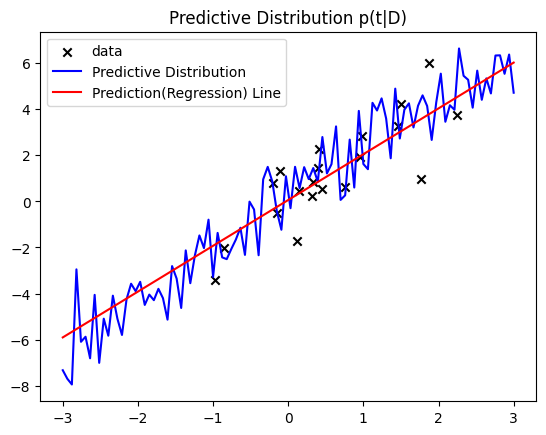

In [22]:
# generate some toy data (N << N_test)
np.random.seed(0)
N = 20
X_train = np.random.randn(N, 1)
y_train = 2*X_train + np.random.randn(N, 1)

blr = BayesianLinearRegression(alpha=1, beta=1)
blr.fit(X_train, y_train)

# make predictions on test data (N_test >> N), so we can view the p(t|D) clearly
N_test = 100
X_test = np.linspace(-3, 3, N_test).reshape(-1, 1)
y_pred = np.zeros(N_test)
y_distribution = np.zeros(N_test)
for i in range(N_test):
    y_distribution[i] = blr.distribution(X_test[i:i+1])[0]
    y_pred[i] = blr.predict(X_test[i:i+1])
# plot the results
plt.scatter(X_train.ravel(), y_train.ravel(), marker='x', color='k', label='data')
plt.plot(X_test.ravel(), y_distribution.ravel(), color='b', label='Predictive Distribution')
plt.plot(X_test.ravel(), y_pred.ravel(), color='r', label='Prediction(Regression) Line')
plt.title("Predictive Distribution p(t|D)")
plt.legend()
plt.show()


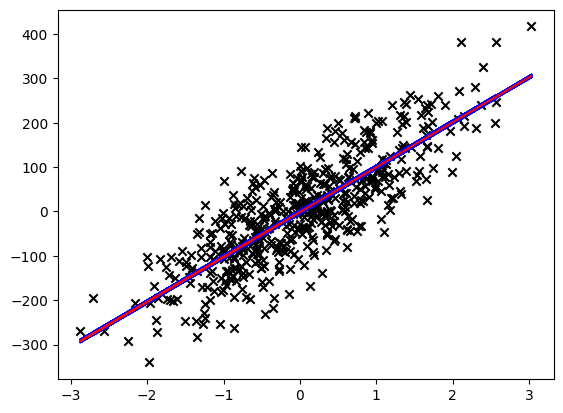

In [23]:
plt.scatter(X.ravel(), y.ravel(), marker='x', color='k', label='data')
plt.plot(X.ravel(), model.distribution(X), color='b')
plt.plot(X.ravel(), model.predict(X), color='r')
plt.show()


In [24]:
metrics(y,y_hat(X))
metrics(y,y_hat2(X,Wml))
metrics(y2,y_hat2(X2,Wml3))
metrics(y,model.predict(X))
metrics(y2,model2.predict(X2))


MSE:  4809.661274075745
RMSE:  69.35172149323868
MAE:  55.770577357203045
R2:  0.6718053549624465

MSE:  4809.661274075745
RMSE:  69.35172149323868
MAE:  55.770577357203045
R2:  0.6718053549624465

MSE:  5169.495236414709
RMSE:  71.89920191778702
MAE:  57.75148441833993
R2:  0.7290528405354977

MSE:  4809.704276043138
RMSE:  69.35203152066374
MAE:  55.75869701575428
R2:  0.6718024206569685

MSE:  5169.544776584923
RMSE:  71.89954642822806
MAE:  57.74108569710078
R2:  0.7290502440018354



## Gradient Descent
$$
w^{(τ +1)} = w^{(τ )} − η∇En
$$
The value of w is initialized to some starting vector w(0) . For the case of the sum-of-squares error function,
$$
w^{(τ +1)} = w^{(τ )} + η(t_n − w^{(τ )T} \phi n )\phi n
$$

where $\phi_n = \phi (x_n )$. This is known as least-mean-squares or the LMS algorithm.

In [25]:
def LMS(X,y,eta=0.001,epoch=1000):
    Phi = np.hstack([np.ones((X.shape[0],1)),X])
    W = np.ones((Phi.shape[1],1))
    for t in range(epoch):
        W = W + (eta * Phi.T @ (y-(Phi @ W)) )
    return W

In [26]:
Wlms = LMS(X,y)

In [27]:
preds = y_hat2(X,Wlms)

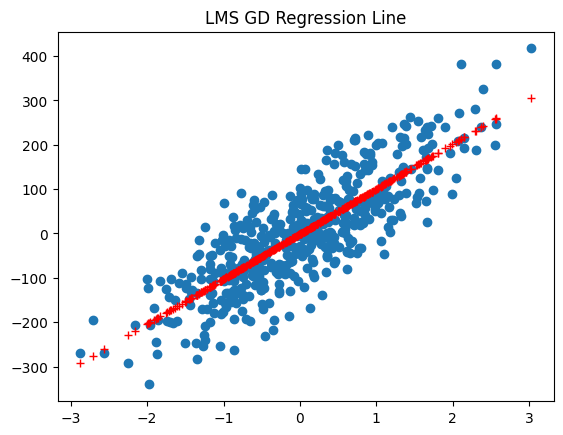

In [28]:
plt.figure()
plt.title("LMS GD Regression Line")
plt.scatter(X,y)
plt.plot(X,preds,'+r')

In [29]:
metrics(y,preds)

MSE:  4809.661274075745
RMSE:  69.35172149323868
MAE:  55.770577357203045
R2:  0.6718053549624465

